In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from matplotlib_venn import *
from statsmodels.stats.multitest import multipletests

# Preprocessing of raw data

## XIST-L1

In [12]:
d = pd.read_excel("data/20240329_Proteomic_XIST_L1.xlsx", sheet_name="RawData")
d = d[[
    "Majority protein IDs", "Fasta headers", 
    "Unique peptides XA1", "Unique peptides XA2", "Unique peptides XA3", 
    "Ratio H/L normalized XA1", "Ratio H/L normalized XA2", "Ratio H/L normalized XA3"]]
d.columns = [
    "Majority protein IDs", "Fasta headers", 
    "Unique peptides R1", "Unique peptides R2", "Unique peptides R3", 
    "Ratio H/L normalized R1", "Ratio H/L normalized R2", "Ratio H/L normalized R3"]
print("All entries:", d.shape)

fcs = [] # log2FC
pvals = [] # p-value
for rs in d[d.columns[-3:]].values:
    fcs.append(np.log2(np.mean(rs)))
    pvals.append(ttest_ind(rs, [1, 1, 1])[1])
d["Log2FC"] = fcs
d["Pvalue"] = pvals

rows = []
for i in range(d.shape[0]):
    row = d.iloc[i]
    for s in row["Majority protein IDs"].split(";"):
        try:
            if s.startswith("sp|"):
                entry = s.split("|")[1]
                row2 = row.copy()
                row2.name = entry
                rows.append(row2)
        except IndexError:
            continue
d = pd.DataFrame(rows)
d.index.name = "Entry"
print("Filtered entries:", d.shape)

# FDR
tmp = d[(d["Unique peptides R1"] >= 2) \
    & (d["Unique peptides R2"] >= 2) \
    & (d["Unique peptides R3"] >= 2) \
    & (~d["Ratio H/L normalized R1"].isna()) \
    & (~d["Ratio H/L normalized R2"].isna()) \
    & (~d["Ratio H/L normalized R3"].isna())].copy()
print("Filtered entries:", tmp.shape)
rejected, corrected_p_values, _, _ = multipletests(tmp["Pvalue"], alpha=0.05, method='fdr_bh')
mapper = {k: v for k, v in zip(tmp.index, corrected_p_values)}
d["FDR"] = d.index.map(mapper)

d.to_csv("results/Proteomic_XIST_L1.csv")

All entries: (1634, 8)
Filtered entries: (1747, 10)
Filtered entries: (826, 10)


## XIST-L3

In [14]:
# Process XIST-L3

d = pd.read_excel("data/20240320_Proteomic_XIST_L3.xlsx", sheet_name="RawData")
d = d[[
    "Majority protein IDs", "Fasta headers", 
    "Unique peptides XE1", "Unique peptides XE3", "Unique peptides XE5", 
    "Ratio H/L normalized XE1", "Ratio H/L normalized XE3", "Ratio H/L normalized XE5"]]
d.columns = [
    "Majority protein IDs", "Fasta headers", 
    "Unique peptides R1", "Unique peptides R2", "Unique peptides R3", 
    "Ratio H/L normalized R1", "Ratio H/L normalized R2", "Ratio H/L normalized R3"]
print("All entries:", d.shape)

fcs = [] # log2FC
pvals = [] # p-value
for rs in d[["Ratio H/L normalized R1", "Ratio H/L normalized R2", "Ratio H/L normalized R3"]].values:
    fcs.append(np.log2(np.mean(rs)))
    pvals.append(ttest_ind(rs, [1, 1, 1])[1])
d["Log2FC"] = fcs
d["Pvalue"] = pvals

rows = []
for i in range(d.shape[0]):
    row = d.iloc[i]
    for s in row["Majority protein IDs"].split(";"):
        try:
            if s.startswith("sp|"):
                entry = s.split("|")[1]
                row2 = row.copy()
                row2.name = entry
                rows.append(row2)
        except IndexError:
            continue
d = pd.DataFrame(rows)
d.index.name = "Entry"
print("Filtered entries:", d.shape)

# FDR
tmp = d[(d["Unique peptides R1"] >= 2) \
    & (d["Unique peptides R2"] >= 2) \
    & (d["Unique peptides R3"] >= 2) \
    & (~d["Ratio H/L normalized R1"].isna()) \
    & (~d["Ratio H/L normalized R2"].isna()) \
    & (~d["Ratio H/L normalized R3"].isna())].copy()
print("Filtered entries:", tmp.shape)
rejected, corrected_p_values, _, _ = multipletests(tmp["Pvalue"], alpha=0.05, method='fdr_bh')
mapper = {k: v for k, v in zip(tmp.index, corrected_p_values)}
d["FDR"] = d.index.map(mapper)

d.to_csv("results/Proteomic_XIST_L3.csv")

All entries: (2021, 8)
Filtered entries: (2164, 10)
Filtered entries: (708, 10)


# Overlap of replicates (Extended Data Figure 3a,b)

--------------------------------------------------------------------------------
Name: L1
Rep1: 1068
Rep1: 1095
Rep1: 1079


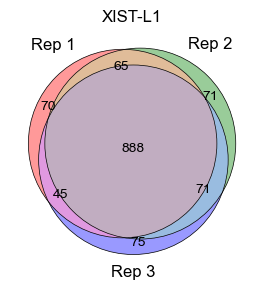

--------------------------------------------------------------------------------
Name: L3
Rep1: 952
Rep1: 956
Rep1: 925


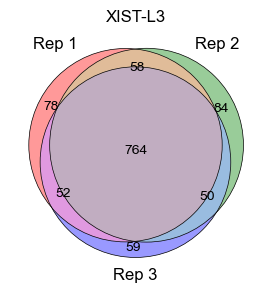

In [20]:
for name in ["L1", "L3"]:
    print("-" * 80)
    print("Name:", name)
    d = pd.read_csv("results/Proteomic_XIST_%s.csv" % name, index_col=0)
    d1 = d[d["Unique peptides R1"] >= 2]
    d2 = d[d["Unique peptides R2"] >= 2]
    d3 = d[d["Unique peptides R3"] >= 2]
    vs1 = set(d1.index)
    vs2 = set(d2.index)
    vs3 = set(d3.index)
    print("Rep1:", len(vs1))
    print("Rep1:", len(vs2))
    print("Rep1:", len(vs3))
    
    array = [vs1, vs2, vs3]
    plt.figure(figsize=(3, 3))
    plt.title("XIST-%s" % name)
    venn3(array, set_labels=["Rep 1", "Rep 2", "Rep 3"])
    venn3_circles(array, lw=0.5)
    plt.tight_layout()
    plt.savefig("figures/Proteomic_XIST_%s.venn3.pdf" % name)
    plt.show()
    plt.close()

# Enrichment of proteins (Figure 2c,d)

--------------------------------------------------------------------------------
Name: L1
Filtered entries: (826, 11)
Up-regulated entries: (90, 11)
ZC3H8 x: 0.95 y: 1.69
PTBP1 x: 0.77 y: 1.7
DDX17 x: 0.62 y: 1.73


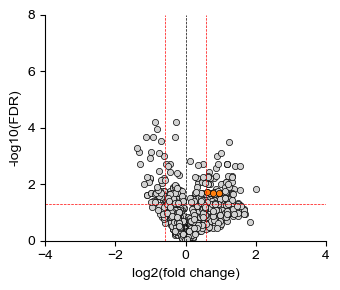

--------------------------------------------------------------------------------
Name: L3
Filtered entries: (708, 11)
Up-regulated entries: (274, 11)
GPKOW x: 1.49 y: 2.23
ZRANB2 x: 1.52 y: 2.28
BUD13 x: 1.43 y: 2.34
DDX55 x: 0.94 y: 2.54
DDX5 x: 1.11 y: 2.13
PTBP1 x: 1.13 y: 2.07
DDX17 x: 0.65 y: 2.32


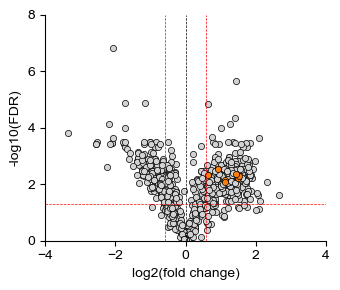

In [23]:
for name in ["L1", "L3"]:
    print("-" * 80)
    print("Name:", name)
    d = pd.read_csv("results/Proteomic_XIST_%s.csv" % name, index_col=0)
    d = d[(d["Unique peptides R1"] >= 2) \
        & (d["Unique peptides R2"] >= 2) \
        & (d["Unique peptides R3"] >= 2) \
        & (~d["Ratio H/L normalized R1"].isna()) \
        & (~d["Ratio H/L normalized R2"].isna()) \
        & (~d["Ratio H/L normalized R3"].isna())].copy()
    print("Filtered entries:", d.shape)

    tmp = d[(d["FDR"] < 0.05) & (d["Log2FC"] > np.log2(1.5))]
    print("Up-regulated entries:", tmp.shape)

    xs, ys = d["Log2FC"], -np.log10(d["FDR"])
    
    plt.figure(figsize=(3.5, 3))
    plt.scatter(xs, ys, edgecolor="black", lw=0.5, color="lightgrey", s=20)
    plt.xlabel("log2(fold change)")
    plt.ylabel("-log10(FDR)")
    plt.axhline(-np.log10(0.05), ls="--", lw=0.5, color="red")
    plt.axvline(-np.log2(1.5), ls="--", lw=0.5, color="red")
    plt.axvline(0, ls="--", lw=0.5, color="black")
    plt.axvline(np.log2(1.5), ls="--", lw=0.5, color="red")
    if name == "L1":
        genes = ["ZC3H8", "PTBP1", "DDX17"]
        for g in genes:
            d1 = d[[isinstance(s, str) and g in s for s in d["Fasta headers"]]]
            if len(d1) == 0:
                print("%s not exists" % g)
            else:
                x = d1["Log2FC"].values[0]
                y = -np.log10(d1["FDR"].values[0])
                print(g, "x:", round(x, 2), "y:", round(y, 2))
                plt.scatter(x, y, edgecolor="black", lw=0.5, color="C1", s=20)
    if name == "L3":
        genes = ["GPKOW", "ZRANB2", "BUD13", "DDX55", "DDX5", "PTBP1", "DDX17"]
        for g in genes:
            d1 = d[[isinstance(s, str) and g in s for s in d["Fasta headers"]]]
            if len(d1) == 0:
                print("%s not exists" % g)
            else:
                x = d1["Log2FC"].values[0]
                y = -np.log10(d1["FDR"].values[0])
                print(g, "x:", round(x, 2), "y:", round(y, 2))
                plt.scatter(x, y, edgecolor="black", lw=0.5, color="C1", s=20)
    
    plt.xlim(-4, 4)
    plt.ylim(0, 8)
    plt.yticks([0, 2, 4, 6, 8])
    for loc in ["top", "right"]:
        plt.gca().spines[loc].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/Proteomic_XIST_%s.scatter.pdf" % name)
    plt.show()
    plt.close()